Spline 2D test
6.8550495298089596e-18
0.000272891300476503
0.0005466670476572301
0.0008222180464283545
0.001100447897906235
0.001382279598764254
0.0016686623863848967
0.0019605789191936493
0.002259052888150786
0.002565157163993185
0.0028800225956775107
0.0032048475888939794
0.0035409086098942303
0.0038895717797026216
0.00425230574767096
0.004630696062049875
0.005026461289719975
0.005441471178606149
0.005877767206012799
0.006337585915931021
0.006823385520468253
0.007337876327661566
0.00788405566345702
0.008465248083830658
0.009085151829247871
0.009747892664669522
0.01045808648268699
0.011220912336012709
0.012042197922418611
0.01292851998821862
0.013887322668659689
0.0149270574751188
0.016057349508916036
0.017289195581134745
0.018635201314702282
0.02010986608880697
0.021729926976166707
0.02351477578141535
0.02548696713116315
0.027672840588836314
0.03010328637568205
0.032814693033558905
0.035850127045473745
0.03926081013178083
0.04310798121523514
0.04746525911469459
0.05242166208592512
0.

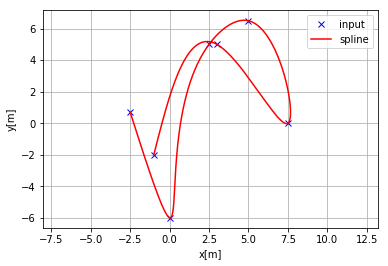

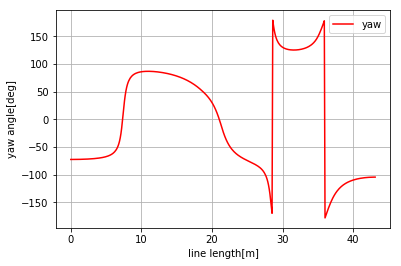

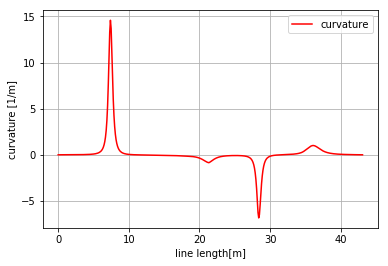

In [62]:
"""
Cubic spline planner
Author: Atsushi Sakai(@Atsushi_twi)
"""
import math
import numpy as np
import bisect


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
            print('hola')
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        #print(dx)
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class
    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)
        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        print(k)
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        #print(yaw)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s


def main():
    print("Spline 2D test")
    import matplotlib.pyplot as plt
    x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -1.0]
    y = [0.7, -6, 5, 6.5, 0.0, 5.0, -2.0]
    ds = 0.1  # [m] distance of each intepolated points

    sp = Spline2D(x, y)
    s = np.arange(0, sp.s[-1], ds)

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        #print(i_s)
        ix, iy = sp.calc_position(i_s)
        #print(ix)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    flg, ax = plt.subplots(1)
    plt.plot(x, y, "xb", label="input")
    plt.plot(rx, ry, "-r", label="spline")
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.legend()

    flg, ax = plt.subplots(1)
    plt.plot(s, [math.degrees(iyaw) for iyaw in ryaw], "-r", label="yaw")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    flg, ax = plt.subplots(1)
    plt.plot(s, rk, "-r", label="curvature")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()


if __name__ == '__main__':
    main()